In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import spatial
from collections import defaultdict
import random
#from purpleair.sensor import Sensor
#from purpleair.network import SensorList
import pickle
from datetime import datetime, timedelta

import os
import sys
from datetime import datetime
from os.path import expanduser
import urllib
import json

ImportError: cannot import name 'Sensor' from 'purpleair' (/home/javier/.local/lib/python3.12/site-packages/purpleair/__init__.py)

In [4]:
API_KEY = "96602008-3701-466F-982E-7F022DFDBBAD"

## Set the longitude/latitude coordinates of the sensor area
min_lon = -123.948
max_lon = -119.246
min_lat = 35.853
max_lat = 39.724
BBox = ((min_lon, max_lon,      
        min_lat, max_lat))

## Set dates and times over collected data:
start_date = "2021-02-09"
start_hour = "0"
end_date = "2021-02-13"
end_hour = "23"

# start_date = "2021-05-01"
# start_hour = "0"
# end_date = "2021-05-03"
# end_hour = "23"

year = int(end_date[0:4])
month = int(end_date[5:7])
day = int(end_date[8:])

## Map image - insert the correct path on your device
#sf_map_img = plt.imread('/Users/kgilman/Desktop/aqi-dataset-experiments/central_CA_map.png')

In [5]:
# API parameters
options = {}
options["url"] = "https://airnowapi.org/aq/data/"
options["start_date"] = start_date
options["start_hour_utc"] = start_hour
options["end_date"] = end_date
options["end_hour_utc"] = end_hour
options["parameters"] = "pm25"
options["bbox"] = str(min_lon) + "," + str(min_lat) + "," + str(max_lon) + "," + str(max_lat)
options["data_type"] = "a"
options["format"] = "json"
options["ext"] = "json"
options["api_key"] = API_KEY

# API request URL
REQUEST_URL = options["url"] \
              + "?startdate=" + options["start_date"] \
              + "t" + options["start_hour_utc"] \
              + "&enddate=" + options["end_date"] \
              + "t" + options["end_hour_utc"] \
              + "&parameters=" + options["parameters"] \
              + "&bbox=" + options["bbox"] \
              + "&datatype=" + options["data_type"] \
              + "&format=" + options["format"] \
              + "&api_key=" + options["api_key"]

try:
    # Request AirNowAPI data
    print("Requesting AirNowAPI data...")

    # User's home directory.
    home_dir = expanduser("~")
    download_file_name = "AirNowAPI" + datetime.now().strftime("_%Y%M%d%H%M%S." + options["ext"])
    download_file = os.path.join(home_dir, download_file_name)

    # Perform the AirNow API data request
#     api_data = urllib.URLopener()
#     api_data = urllib.request.urlopen(REQUEST_URL)
#     api_data.retrieve(REQUEST_URL, download_file)

    response = urllib.request.urlopen(REQUEST_URL)

    data = json.loads(response.read())

#     data = api_data.read()

    # Download complete
    print("Download URL: %s" % REQUEST_URL)
    print("Download File: %s" % download_file)

except Exception as e:
    print("Unable perform AirNowAPI request. %s" % e)
    sys.exit(1)

Requesting AirNowAPI data...
Download URL: https://airnowapi.org/aq/data/?startdate=2021-02-09t0&enddate=2021-02-13t23&parameters=pm25&bbox=-123.948,35.853,-119.246,39.724&datatype=a&format=json&api_key=96602008-3701-466F-982E-7F022DFDBBAD
Download File: /home/javier/AirNowAPI_20230421110458.json


#### Get AirNow Sensor coordinates

In [7]:
### Filter for unique long/lat coordinates
data_lat = []
data_lon = []
for sensor in data:
    data_lat.append(sensor['Latitude'])
    data_lon.append(sensor['Longitude'])
    
airnow_sensors = []
for item in zip(data_lon,data_lat):
    if(item not in airnow_sensors):
        airnow_sensors.append(item)

d = len(airnow_sensors)
print("Number of AirNow Sensors: " + str(d))

airnow_lon = []
airnow_lat = []
for sensor in airnow_sensors:
    airnow_lon.append(sensor[0])
    airnow_lat.append(sensor[1])

Number of AirNow Sensors: 63


#### Plot sensor locations over map

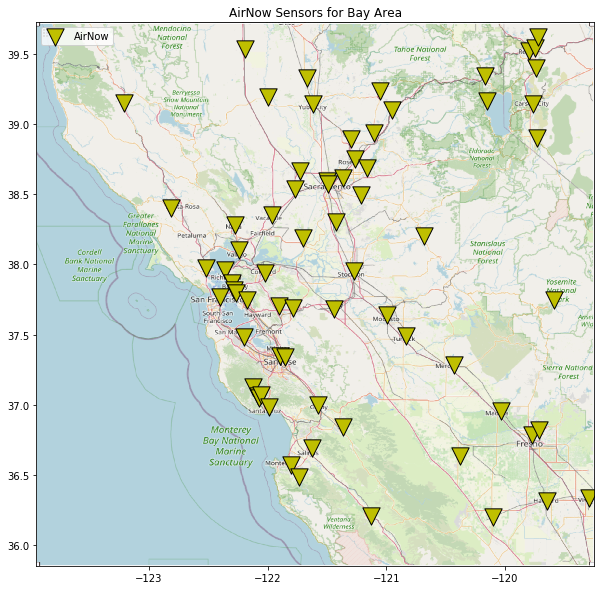

In [36]:
from scipy.spatial import Voronoi, voronoi_plot_2d
# points = (data_lon, data_lat)
vor = Voronoi(airnow_sensors)
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.imshow(sf_map_img, zorder=0, extent = BBox, aspect= 'auto')
# voronoi_plot_2d(vor, show_vertices=False, line_colors='orange',line_width=2, line_alpha=1, point_size=2,ax=ax)
# ax.scatter(bay_df.lon, bay_df.lat, zorder=1, alpha= 0.5, c='purple', s=20,label="PurpleAir")
ax.scatter(airnow_lon, airnow_lat, zorder=1, alpha= 1, c='y', s=300,marker="v",edgecolors='k',label="AirNow")
ax.set_title('AirNow Sensors for Bay Area')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
plt.legend()
plt.show()

### Obtain PurpleAir Sensors

Get all PurpleAir sensors within the coordinates range set above. For now, only include "useful" (i.e. functioning) and outdoor sensors.

##### For now, get one week of PAST data. You'll have to change weeks_to_get if end_date is more than one week past start_date

##### Caution: This block takes a while to run! Skip to next block to read in the dataframe if you already have it stored in memory.

##### Read in the dataframe from saved pkl

In [14]:
import pandas as pd
bay_df = pd.read_pickle(r'bay_df.pkl')

#### Plot PurpleAir on map

#### Obtain nearest PurpleAir sensors to each AirNow sensor (store indices from bay_df in dict "nearestkpurple")

In [17]:
### Sort PurpleAir into Voronoi cells by AirNow sensor location
airnow_purple_dict = defaultdict(list)
for bay_index,pt in enumerate(zip(bay_df.lon.tolist(),bay_df.lat.tolist())):
    index = spatial.KDTree(airnow_sensors).query(pt)[1]
    airnow_key = airnow_sensors[index]
    airnow_purple_dict[airnow_key].append(bay_index)
    
### Remove AirNow sensors with fewer than min_num_purple # of nearby PurpleAir sensors 
min_num_purple = 10
removed = []
for (idx,sensor) in enumerate(airnow_sensors):
    if(len(airnow_purple_dict[sensor]) < min_num_purple):
        del airnow_purple_dict[sensor]
        removed.append(sensor)

for sensor in removed:
    airnow_sensors.remove(sensor)
    
airnow_lat = []
airnow_lon = []
for sensor in airnow_sensors:
    airnow_lat.append(sensor[1])
    airnow_lon.append(sensor[0])

In [18]:
print(len(airnow_sensors))

46


#### Get k-nearest neighboring PurpleAir sensors to each AirNow sensor (for now use 10)

In [20]:
# min_num_purple = min([len(airnow_purple_dict[key]) for key in airnow_purple_dict])
min_num_purple = 10;
nearestkpurple_candidates = {}
for key in airnow_purple_dict:
#     airnow_purple_dict[key] = random.sample(airnow_purple_dict[key],min_num_purple) ##for random sensors in each Voronoi cell

    purple_sensors_idx = airnow_purple_dict[key]
    purple_sensors = []
    for item in zip(bay_df.iloc[purple_sensors_idx].lon, bay_df.iloc[purple_sensors_idx].lat):
        purple_sensors.append(item)#pm2.5_cf_1

    nearest_idx = spatial.KDTree(purple_sensors).query(key,k=min_num_purple)[1]
    candidates = [airnow_purple_dict[key][i] for i in nearest_idx]
    nearestkpurple_candidates[key] = candidates

In [21]:
nearestkpurple = {}
for key in nearestkpurple_candidates:
    nearestkpurple[key] = nearestkpurple_candidates[key][:min_num_purple]

#### Plot k-nearest PurpleAir sensors to AirNow

### Assemble the datasets

In [22]:
time_record = defaultdict(list)      ## make dictionary of all time keys to keep time
airnow_data_dict = defaultdict(list) ## make dictionary hashed by (AirNow sensor coordinates x time) keys
for entry in data:
    airnow_key = (entry['Longitude'],entry['Latitude'])
    time_key = entry['UTC']
    if(time_key not in time_record):
        time_record[time_key]
    airnow_data_dict[(airnow_key,time_key)] = entry['AQI']

##### Construct AirNow data matrix

Data matrix is Sensor x Time.

In [23]:
output_airnow_data = np.zeros((len(airnow_sensors),len(time_record)))

for t,time_key in enumerate(time_record):
    for (i,airnow_key) in enumerate(airnow_sensors):
        if(not airnow_data_dict[(airnow_key,time_key)]):
            output_airnow_data[i,t] = np.nan
        else:
            output_airnow_data[i,t] = airnow_data_dict[(airnow_key,time_key)]

In [25]:
T = output_airnow_data.shape[1]
print(T)

120


In [26]:
### Eliminate any sensor rows with mostly missing entries (10% of entries are missing)
removed_idx = []
removed_sensors = []
for (i,sensor) in enumerate(airnow_sensors):
    if(sum(np.isnan(output_airnow_data[i,:])) > T*0.1):
        removed_idx.append(i)
        removed_sensors.append(sensor)

        
output_airnow_data = np.delete(output_airnow_data, removed_idx, axis=0)

for sensor in removed_sensors:
    airnow_sensors.remove(sensor)

##Update these arrays again (find a way to do this without running this code again?)
airnow_lat = []
airnow_lon = []
for sensor in airnow_sensors:
    airnow_lat.append(sensor[1])
    airnow_lon.append(sensor[0])

In [27]:
output_airnow_data.shape

(40, 120)

In [28]:
len(airnow_sensors)

40

In [29]:
output_airnow_data

array([[32., 26., 23., ..., 16., 14., 18.],
       [39., 32., 24., ..., 11., 18., 17.],
       [47., 51., 46., ..., 33., 31., 38.],
       ...,
       [19., 16., 12., ...,  2.,  7., 10.],
       [92., 87., 87., ...,  8., 10., 11.],
       [11., 18., 19., ...,  2.,  5., 11.]])

In [30]:
### Find time indices of missing AirNow sensor readings
t_remove = ~np.isnan(output_airnow_data).any(axis=0)
output_airnow_data = output_airnow_data[:, t_remove]

Debugging: shape of AirNow matrix: AirNow Sensors (d sensor locations) x Time (T hours)

In [31]:
output_airnow_data.shape

(40, 71)

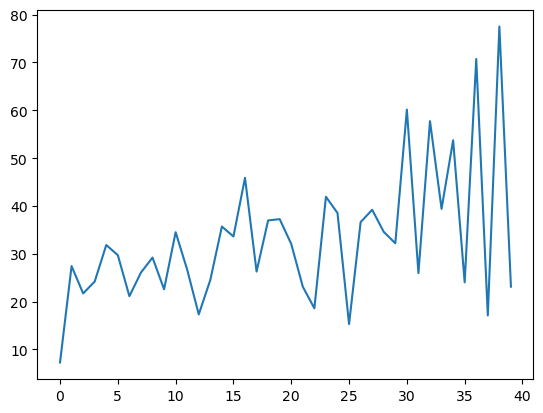

In [43]:
plt.plot(np.mean(output_airnow_data, axis=1))

In [ ]:
for i in range(output_airnow_data.shape[1])

##### Construct PurpleAir data matrix

First construct tensor that is AirNow Sensors (d) x Time (T hours) x PurpleAir Sensors (10).

Flatten into matrix that is Sensor x (Purple Air Sensors) * Time. Each row corresponds to one AirNow sensor location on the map. For each hour in time, there are 10 PurpleAir vectors.

Again, change start_date and weeks_to_get if necessary

In [44]:
### Debugging block
# idx = nearestkpurple[(-120.1488, 39.166)]
for (i,airnow_sensor) in enumerate(airnow_sensors):
    sensor_names = bay_df.index.values[nearestkpurple[airnow_sensor]]
    for name in sensor_names:
        print(name)
        se = Sensor(int(name))
    

82913


NameError: name 'Sensor' is not defined

In [31]:
### Read the time data for each PurpleAir sensor and assign to corresponding AirNow sensor in time

purple_data = defaultdict(list)

## For every row in the matrix (AirNow sensor)
for (i,airnow_sensor) in enumerate(airnow_sensors):
    print('Sensor: ' + np.str(i))
    
    ## Get list of associated nearest k PurpleAir sensors
    sensor_names = bay_df.index.values[nearestkpurple[airnow_sensor]]
    for (j,name) in enumerate(sensor_names): 
        se = Sensor(int(name))
        se_df = se.parent.get_historical(weeks_to_get=1,thingspeak_field='primary',
                                        start_date = datetime(year,month,day+1))
        sensor_times = pd.to_datetime(se_df['created_at'])
        
        ## For each hour of AirNow recording, get the sensor readings (nearest to that hour) from the k PurpleAir sensors
        for (t,time_key) in enumerate(time_record):
            time_diff = abs(sensor_times - pd.to_datetime(time_key))
            tmp_idx = sensor_times.index.get_loc(time_diff.idxmin(0))
            reading = se_df.iloc[tmp_idx]['PM2.5_CF_1_ug/m3']
            
            print("AirNow : " + np.str(airnow_sensor) + " :PurpleAir sensor " + np.str(j) + " at " + np.str(sensor_times.iloc[tmp_idx]) + ': ' + np.str(reading) )
            
            ## Assign to corresponding AirNow/time entry
            purple_data[(airnow_sensor,time_key)].append(reading)

Sensor: 0
AirNow : (-123.206528, 39.150478) :PurpleAir sensor 0 at 2021-02-08 22:11:11: 46.98
AirNow : (-123.206528, 39.150478) :PurpleAir sensor 0 at 2021-02-08 22:11:11: 46.98
AirNow : (-123.206528, 39.150478) :PurpleAir sensor 0 at 2021-02-08 22:11:11: 46.98
AirNow : (-123.206528, 39.150478) :PurpleAir sensor 0 at 2021-02-08 22:11:11: 46.98
AirNow : (-123.206528, 39.150478) :PurpleAir sensor 0 at 2021-02-08 22:11:11: 46.98
AirNow : (-123.206528, 39.150478) :PurpleAir sensor 0 at 2021-02-08 22:11:11: 46.98
AirNow : (-123.206528, 39.150478) :PurpleAir sensor 0 at 2021-02-08 22:11:11: 46.98
AirNow : (-123.206528, 39.150478) :PurpleAir sensor 0 at 2021-02-08 22:11:11: 46.98
AirNow : (-123.206528, 39.150478) :PurpleAir sensor 0 at 2021-02-08 22:11:11: 46.98
AirNow : (-123.206528, 39.150478) :PurpleAir sensor 0 at 2021-02-08 22:11:11: 46.98
AirNow : (-123.206528, 39.150478) :PurpleAir sensor 0 at 2021-02-08 22:11:11: 46.98
AirNow : (-123.206528, 39.150478) :PurpleAir sensor 0 at 2021-02-0

AirNow : (-123.206528, 39.150478) :PurpleAir sensor 1 at 2021-02-09 00:00:18: 7.42
AirNow : (-123.206528, 39.150478) :PurpleAir sensor 1 at 2021-02-09 01:00:18: 7.58
AirNow : (-123.206528, 39.150478) :PurpleAir sensor 1 at 2021-02-09 02:00:18: 8.53
AirNow : (-123.206528, 39.150478) :PurpleAir sensor 1 at 2021-02-09 03:00:18: 7.66
AirNow : (-123.206528, 39.150478) :PurpleAir sensor 1 at 2021-02-09 04:00:18: 6.84
AirNow : (-123.206528, 39.150478) :PurpleAir sensor 1 at 2021-02-09 05:00:18: 5.17
AirNow : (-123.206528, 39.150478) :PurpleAir sensor 1 at 2021-02-09 06:00:18: 9.69
AirNow : (-123.206528, 39.150478) :PurpleAir sensor 1 at 2021-02-09 07:00:20: 9.16
AirNow : (-123.206528, 39.150478) :PurpleAir sensor 1 at 2021-02-09 08:00:18: 8.04
AirNow : (-123.206528, 39.150478) :PurpleAir sensor 1 at 2021-02-09 09:00:18: 6.79
AirNow : (-123.206528, 39.150478) :PurpleAir sensor 1 at 2021-02-09 10:00:18: 3.76
AirNow : (-123.206528, 39.150478) :PurpleAir sensor 1 at 2021-02-09 11:00:18: 4.44
AirN

AirNow : (-123.206528, 39.150478) :PurpleAir sensor 2 at 2021-02-08 23:59:52: 9.72
AirNow : (-123.206528, 39.150478) :PurpleAir sensor 2 at 2021-02-09 00:59:51: 9.64
AirNow : (-123.206528, 39.150478) :PurpleAir sensor 2 at 2021-02-09 01:59:51: 0.0
AirNow : (-123.206528, 39.150478) :PurpleAir sensor 2 at 2021-02-09 02:59:51: 0.22
AirNow : (-123.206528, 39.150478) :PurpleAir sensor 2 at 2021-02-09 03:59:51: 0.12
AirNow : (-123.206528, 39.150478) :PurpleAir sensor 2 at 2021-02-09 04:59:51: 0.0
AirNow : (-123.206528, 39.150478) :PurpleAir sensor 2 at 2021-02-09 05:59:51: 0.0
AirNow : (-123.206528, 39.150478) :PurpleAir sensor 2 at 2021-02-09 06:59:51: 0.0
AirNow : (-123.206528, 39.150478) :PurpleAir sensor 2 at 2021-02-09 07:59:51: 5.07
AirNow : (-123.206528, 39.150478) :PurpleAir sensor 2 at 2021-02-09 08:59:51: 7.75
AirNow : (-123.206528, 39.150478) :PurpleAir sensor 2 at 2021-02-09 09:59:51: 6.96
AirNow : (-123.206528, 39.150478) :PurpleAir sensor 2 at 2021-02-09 10:59:51: 3.64
AirNow :

AirNow : (-123.206528, 39.150478) :PurpleAir sensor 3 at 2021-02-08 23:59:34: 7.63
AirNow : (-123.206528, 39.150478) :PurpleAir sensor 3 at 2021-02-09 00:59:33: 7.56
AirNow : (-123.206528, 39.150478) :PurpleAir sensor 3 at 2021-02-09 01:59:34: 6.83
AirNow : (-123.206528, 39.150478) :PurpleAir sensor 3 at 2021-02-09 02:59:34: 5.25
AirNow : (-123.206528, 39.150478) :PurpleAir sensor 3 at 2021-02-09 03:59:34: 7.2
AirNow : (-123.206528, 39.150478) :PurpleAir sensor 3 at 2021-02-09 04:59:36: 5.96
AirNow : (-123.206528, 39.150478) :PurpleAir sensor 3 at 2021-02-09 05:59:34: 4.26
AirNow : (-123.206528, 39.150478) :PurpleAir sensor 3 at 2021-02-09 06:59:34: 4.07
AirNow : (-123.206528, 39.150478) :PurpleAir sensor 3 at 2021-02-09 07:59:36: 5.46
AirNow : (-123.206528, 39.150478) :PurpleAir sensor 3 at 2021-02-09 08:59:34: 4.55
AirNow : (-123.206528, 39.150478) :PurpleAir sensor 3 at 2021-02-09 09:59:35: 2.64
AirNow : (-123.206528, 39.150478) :PurpleAir sensor 3 at 2021-02-09 10:59:34: 2.67
AirNo

KeyboardInterrupt: 

In [ ]:
### Collect Purple data into tensor
purple_data_tensor = np.zeros((len(airnow_sensors),len(time_record),min_num_purple))

for t,time_key in enumerate(time_record):
    for (i,airnow_key) in enumerate(airnow_sensors):
#         print(len(purple_data[(airnow_key,time_key)]))
        purple_data_tensor[i,t,:] = purple_data[(airnow_key,time_key)]
        
### Reshape tensor into d x nT matrix, d=#AirNow, n=#Purple/AirNow, T = time

purple_data_tensor = purple_data_tensor[:,t_remove,:]

output_purple_data = []

for t in range(0,purple_data_tensor.shape[1]):
    tmp = purple_data_tensor[:,t,:]
    output_purple_data.append(tmp)

output_purple_data = np.concatenate(output_purple_data,axis=1)

Debugging: shape of PurpleAir Data matrix

In [ ]:
output_purple_data.shape